## Experiments with SVD at Movielens 10M

Initial setup: imports and working dir

In [1]:
import os
while not os.path.exists('.gitmodules'):
    os.chdir('..')

from typing import Callable

from bayes_opt import BayesianOptimization

from model.eigen3_svd import Eigen3SVDpp
from parameters import get_env_parameters
from util.bo_eval_utils import KernelFactory, make_svdpp_target_function, \
    make_optimizer, matern_kernel_factory, custom_kernel_factory, \
    evaluate_all_optimizers_or_load_dump, plot_bo_rmse
from util.datasets import MOVIELENS_10M
from util.docker.eigen3_svd import Eigen3SVDService
from util.splits import split_for_eigen3_svd

Start the docker container for native SVD/SVD++ models.
*If either the container or needed image does not exist, they will be created programmatically.*
This behavior is controlled by service constructor flags.

In [2]:
env_params = get_env_parameters()
eigen3_svd_service = Eigen3SVDService(env_params=env_params,
                                      do_init_container=True,
                                      allow_auto_build_image=True,
                                      allow_auto_create_container=True,
                                      allow_auto_run_container=True)

Compile model with all possible factor counts before the experiments.

In [3]:
_ = Eigen3SVDpp.compile([i + 1 for i in range(100)], eigen3_svd_service, verbose=False)

Define train and test sets, target function for Bayesian optimization
and optimizer meta-factory function to create optimizer instances with needed
kernel for Gaussian processes.

In [4]:
train, test = split_for_eigen3_svd(
    dataset_descriptor=MOVIELENS_10M,
    env_params=env_params,
    train_file_name=f'ml10m-train-80.csv',
    test_file_name=f'ml10m-test-20.csv',
    test_size=0.2
)

target_function = make_svdpp_target_function(
    train=train,
    test=test,
    eigen3_svd_service=eigen3_svd_service
)

def make_optimizer_factory(kernel_factory: KernelFactory) -> Callable[[], BayesianOptimization]:
    def factory_function() -> BayesianOptimization:
        return make_optimizer(
            target_function=target_function,
            kernel_factory=kernel_factory
        )
    
    return factory_function

C:\_\svd-pytorch-and-bo\eigen3_svd\data\corpus\ml10m-train-80.csv and C:\_\svd-pytorch-and-bo\eigen3_svd\data\corpus\ml10m-test-20.csv already exists


Define experiment settings:
- evaluation parameters (no. of initial points / manually chosen points, no. of optimization iterations,
no. of evaluations of the same optimizer);
- kernels to evaluate;
- dump file names and experiment ids to save the results.

In [5]:
experiment_settings = {
    'evaluation_settings': {
        'optimization_iter_count': 10,
        'optimizer_evaluations_count': 10,
        'optimizer_init_points': 1,
        'optimizer_probes': None
    },
    'evaluations': [
        {
            'dump_file_name': 'bopp_ml10m_ip1_m25_ucb_x10_no1.csv',
            'optimizers': {
                'Matern 2.5 + ucb (ip 1)': {
                    'optimizer_factory': make_optimizer_factory(
                        matern_kernel_factory(nu=2.5),
                    )
                }
            }
        },
        {
            'dump_file_name': 'bopp_ml10m_ip1_c25_s1e-3_sdi3_ucb_x10_no1.csv',
            'optimizers': {
                'CustomKernel 2.5 s1e-3 sdi3 + ucb (ip 1)': {
                    'optimizer_factory': make_optimizer_factory(
                        custom_kernel_factory(nu=2.5, sigmoid_scale=1e-3, sigmoid_decay_iterations=3),
                    )
                }
            }
        },
        {
            'dump_file_name': 'bopp_ml10m_ip1_c25_s1e-3_sdi4_ucb_x10_no1.csv',
            'optimizers': {
                'CustomKernel 2.5 s1e-3 sdi4 + ucb (ip 1)': {
                    'optimizer_factory': make_optimizer_factory(
                        custom_kernel_factory(nu=2.5, sigmoid_scale=1e-3, sigmoid_decay_iterations=4),
                    )
                }
            }
        },
    ]
}

Run the experiments.
Function ```evaluate_all_optimizers_or_load_dump_df``` runs all the experiments
defined above, saves the results, and returns pandas ```DataFrame``` with
whole evaluation data.

In [6]:
results_df = evaluate_all_optimizers_or_load_dump(experiment_settings)

Results are loaded from results\bopp_ml10m_ip1_m25_ucb_x10_no1.csv
Results are loaded from results\bopp_ml10m_ip1_c25_s1e-3_sdi3_ucb_x10_no1.csv
Results are loaded from results\bopp_ml10m_ip1_c25_s1e-3_sdi4_ucb_x10_no1.csv


Visualize model RMSE decrease per second and per iteration.
Plots contain mean values with 95% confidence interval.

C:\_\svd-pytorch-and-bo\util\bo_eval_utils.py:657: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


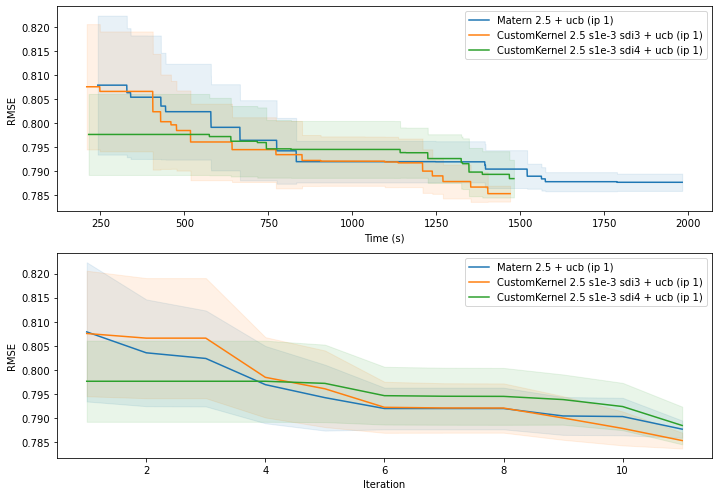

In [7]:
plot_bo_rmse(results_df, figsize=(10, 7))